# CS145: Project 3 | The Effects of External, Non-game Factors on NCAA Basketball Game Outcomes and Performances


* *Roy Yuan


## Project Overview

---
We are using the ‘ncaa_basketball’ to explore how external factors affect the outcomes of games/team performance. By external factors, we mean factors which are not related to statistics derived from play on the court like points allowed, points scored, etc. We also will look into how statistics outside of the players’ control impact a game’s outcome between evenly-matched teams, which are teams with similar win-loss records (win percentages within 5% of each other). 

Some features we will explore in regards to their impact on game outcomes (win percentages/outcomes) are **team color**, **venue attendance**, the **venue location (home or away)**, and **average class (freshman, sophomore, junior, senior, grad student) of the players**. Additionally, we will analyze how attendance at games affects 3-point shots, one of the most impactful and focus-intensive plays belonging to the game of basketball. We hope to answer the question: **do these external factors really matter in NCAA basketball?**


---


## Analysis of Dataset

---
The tables we are using are the following: mbb_games_sr, mbb_teams_games_sr, mbb_pbp_sr, mbb_teams, and team_colors. 

mbb_games_sr:      
This table has 48.08 MB. At a high level, the information that this table features is team-level box scores from every men's basketball game from the 2013-14 season to the 2017-18 season. Each row displays both team’s stats for that one game played between them. The table has the team names, venue name, and outcome of the game, and using information like the team name, we can look at the other tables we are using to find relevant information about that team. 
Foreign Key: game_id, team_id
Key: game_id, team_id

mbb_teams_games_sr:
This table has 421.03 MB. It provides statistics on players for each game from the 2013-14 season to the 2017-18 season. It has information on player class, which will be useful in our exploration into whether average team class has an effect on game outcomes/performance.
Foreign Key: game_id, team_id
Key: game_id, team_id

mbb_pbp_sr:
This table has 3.14 GB of data. It has play-by-play data from men's basketball games starting from the 2013-14 season. We will use this data to compute three-point make percentage in our exploration into whether attendance has an affect on three-pointer ability of teams.
Foreign Key: game_id, team_id
Key: game_id, team_id

mbb_teams:     
This table has 225 KB. At a high level, this table contains information about each men’s basketball team, notably league, home venue, conference, and division. When two teams are matched up against each other, we can look by team name for each team’s individual information that does not relate to statistics, and see if there is any correlation between that and the outcome of the game. 
Foreign Key: game_id, team_id
Key: game_id, team_id

team_colors:     
This table has 23.35 KB. At a high level, this table has the hex color codes of each Division 1 basketball team. From each played game, we can see what color each of the competing teams are (from mbb_games_sr), which is one of the non-statistical factors we are looking at to see if it has an effect on the game’s outcome. A difficulty with this table is that the color codes are in hex, so we approached this by looking at a range of colors that included red (brighter red, shades like brownish red/dark maroon don't count) and manually removing some of the teams were not red. Most of the teams we removed were a yellow or tan color. 
Foreign Key: market
Key: market

----

## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "project3-334106"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import numpy as np

## Data Exploration: Game Venue

One of our initial questions was if game venue mattered. To tackle this, we used the following tables: `bigquery-public-data.ncaa_basketball.mbb_games_sr` and `bigquery-public-data.ncaa_basketball.mbb_teams`. Our approach was to first determine how many games each team played as the home team or the away team. 

To calculate win percentage, we compared columns that held scores to make anbother column called "win" that held a boolean value which denoted if the home team won (1 means home team won). We then did this in another separate table but this time, a present 1 value denoted that the away team won. 

With the number of wins and the number of total games, we could compute the percentage of wins by a certain team when they are home or away. 

We then created a bar graph that compared "how many teams won a higher percentage of games at home" and "how many teams won a higher percentage of games at away".  

The queries include all teams, regardless of strength in matchup.

In [ ]:
#@title Query for "Total Games Played by a Team"
%%bigquery --project $project_id
WITH home_gp as (
  SELECT COUNT(sr.h_market) as home_games, teams.market
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr, `bigquery-public-data.ncaa_basketball.mbb_teams` as teams
  WHERE sr.h_market = teams.market
  GROUP BY teams.market 
), away_gp as (
  SELECT COUNT(a_market) as away_games, teams.market
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr, `bigquery-public-data.ncaa_basketball.mbb_teams` as teams
  WHERE sr.a_market = teams.market
  GROUP BY teams.market 
), total_gp as (
  SELECT home_games, away_games, home_games + away_games as total_games, home_gp.market
  FROM home_gp
  JOIN away_gp ON home_gp.market = away_gp.market
)
SELECT * 
FROM total_gp


In [ ]:
#@title Query for "Win Percentage at Home, Win Percentage at Away, and Total Win Percentage"
%%bigquery --project $project_id
WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away, 
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
)
SELECT *
FROM percents

In [ ]:
#@title Query for Number of Teams with a Higher Win Percentage at "Home vs. Number of Teams with a Higher Win Percentage at Away"
%%bigquery --project $project_id 
WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away, 
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), home_or_away_win as (
  SELECT IF(percents.win_percent_as_home > percents.win_percent_as_away, 1, 0) as more_wins_as_home
  FROM percents
), more_x_wins as (
  SELECT SUM(more_wins_as_home) as more_wins_as_home, COUNT(more_wins_as_home) - SUM(more_wins_as_home) as more_wins_as_away 
  FROM home_or_away_win
)

SELECT *
FROM more_x_wins

Text(0.5, 1.0, 'Teams with More Wins as Home vs. Teams with More Wins as Away')

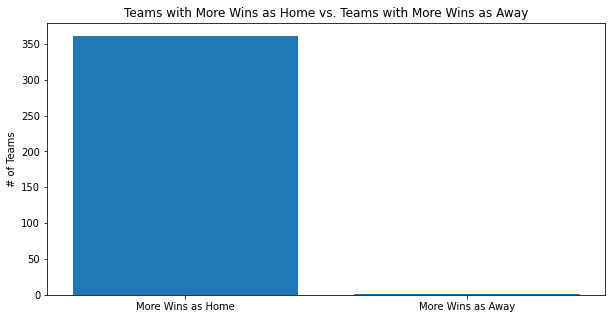

In [ ]:
#@title Plot for "Teams with More Wins as Home vs. Teams with More Wins as Away"
plt.figure(figsize=(10, 5))
x = ["More Wins as Home", "More Wins as Away"]
y = [361, 1] #values that we saw from query up above
plt.bar(x, y)
plt.ylabel("# of Teams")
plt.title("Teams with More Wins as Home vs. Teams with More Wins as Away")

361 of the 362 teams won more games as the home team as opposed to the away team. Clearly, home court advantage makes a huge difference in NCAA D1 basketball. 

Let's look at a bit more data, specficially distribution of win percentages at home vs. distribution of win percentages at away.

The y-axis shows the winning percentage of a team, and the x-axis is supposed to be a layout of all the teams, but we removed the x-tick marks to avoid the mass clutter of 362 teams.

In [ ]:
#@title Query for "Away Win Loss"

%%bigquery --project $project_id a_WL

WITH awayWL as (
  SELECT teams.market as home_team, sr.h_market, sr.h_points_game, sr.a_market, sr.a_points_game, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr, `bigquery-public-data.ncaa_basketball.mbb_teams` as teams
  WHERE sr.venue_id = teams.venue_id AND sr.h_market = teams.market # they have home team adv
), totals as (
  SELECT COUNT(win) as total_games, a_market
  FROM awayWL
  GROUP BY a_market
), won as (
  SELECT COUNT(win) as games_won, a_market
  FROM awayWL
  WHERE win = 1
  GROUP BY a_market
), combined as (
  SELECT total_games, games_won, totals.a_market
  FROM totals
  JOIN won ON totals.a_market = won.a_market
)

SELECT *, ROUND(100.0 * games_won / total_games, 2) as away_win_percentage
from combined
ORDER BY away_win_percentage DESC


In [ ]:
#@title Query for "Home Win Loss"
%%bigquery --project $project_id home_wl

WITH homeWL as (
  SELECT teams.market as home_team, sr.h_market, sr.h_points_game, sr.a_market, sr.a_points_game, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr, `bigquery-public-data.ncaa_basketball.mbb_teams` as teams
  WHERE sr.venue_id = teams.venue_id AND sr.h_market = teams.market # they have home team adv
), totals as (
  SELECT COUNT(win) as total_games, home_team
  FROM homeWL
  GROUP BY home_team
), won as (
  SELECT COUNT(win) as games_won, home_team
  FROM homeWL
  WHERE win = 1
  GROUP BY home_team
), combined as (
  SELECT total_games, games_won, totals.home_team
  FROM totals
  JOIN won ON totals.home_team = won.home_team
)

SELECT *, ROUND(100.0 * games_won / total_games, 2) as home_win_percentage
from combined
ORDER BY home_win_percentage DESC



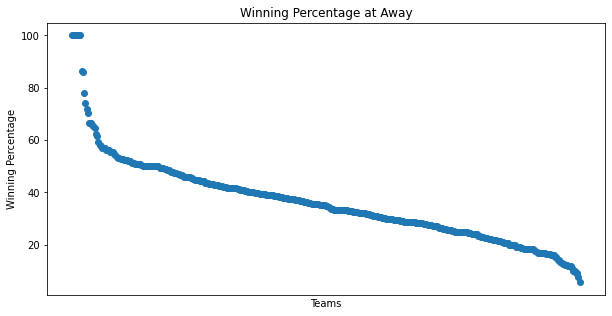

In [ ]:
#@title Plot for Distribution of "Winning Percentage at Away"
plt.figure(figsize=(10, 5))
plt.scatter(a_WL["a_market"], a_WL["away_win_percentage"])
plt.title("Winning Percentage at Away")
plt.xlabel("Teams")
plt.ylabel("Winning Percentage")
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

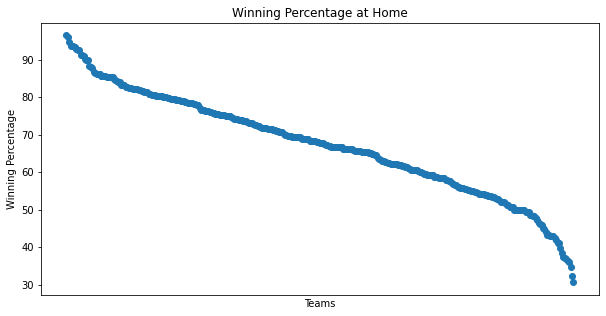

In [ ]:
#@title Plot for Distribution of "Winning Percentage at Home"
plt.figure(figsize=(10, 5))
plt.scatter(home_wl["home_team"], home_wl["home_win_percentage"])
plt.title("Winning Percentage at Home")
plt.xlabel("Teams")
plt.ylabel("Winning Percentage")
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)



We came into the project hypothesizing that home court advantage would make a difference, but were shocked to see how huge of a difference it made: 99.7% of teams have a higher winning percentage at home compared to winning percentage at away. 

Our results were further reinforced with the distribution of win percentages at home vs. distribution of win percentages at away: more teams won over 50% of games at home and more teams lost over 50% games at away.

It should be noted that we did not consider if a matchup was "evenly_matched", a term we will define later in the data exploration. A potential hypothesis for the higher win percentage at home is because a lot of times, teams try to host more opponents they can beat compared to stronger opponents in order to attract a home crowd and to win in front of fans rooting for the home team. Additionally, players have practiced more in the facility that is the game venue when they have the home court advantage, so the home team may make more shots since these are the hoops they practice on every day. Other reasons may include the lack of a need to travel to the opponent's venue, which usually consists of a long car/plane ride and can affect performance due to sitting around too long. Essentially, we hypothesize that players are more comfortable playing in their home environment since they are familiar with it, and that weaker teams are hosted as opposed to strong ones, which means a team is more likely to win at home rather than away.

## Data Exploration:  Evenly Matched Teams 

Before we get started, let's define what an "evenly matched" team is. By our definition, two teams are evenly matched if their total win percentage is within 5% of each other. 

We want to look at even matchups because this way, we can mitigate the factor that is a huge difference in between two teams' strengths (ie. 99% win rate team vs 10% win rate team). Because two teams are evenly matched, we can consider other outside factors that are not statistic based and see how those external factors may affect the game, and if there is any sort of correlation. For this, we used the `bigquery-public-data.ncaa_basketball.mbb_games_sr` to analyze each game and calculated a team's total win rate and compared it to its opponents to determine if two teams are even matchups.

In [ ]:
#@title Query for Games Between Evenly Matched Teams
%%bigquery --project $project_id
#evenly matched
WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away, 
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), percents2 as (
  SELECT *
  FROM percents
), matchups as (
  SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away, 
    percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
    ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
  FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  WHERE sr.h_market = percents.team AND sr.a_market = percents2.team 
    AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
)
 
SELECT *, IF(h_points_game > a_points_game, 1, 0) as home_won
FROM matchups


## Data Exploration: Effect of Home Court Advantage in Even Matchups

The first outside factor we want to look at is game venue, namely home court advantage. We already know that home court advantage makes a massive difference from our explorations above, but what about with teams that are evenly matched? 

The y-axis shows the winning percentage of a team, and the x-axis is supposed to be a layout of all the teams, but we removed the x-tick marks to avoid the mass clutter of teams.

We used the `bigquery-public-data.ncaa_basketball.mbb_games_sr` table to find our results.

In [ ]:
#@title Query for "Win Loss % Against Evenly Matched Teams (Home and Away)"
#WIN LOSS % AGAINST EVENLY MATCHED TEAMS
%%bigquery --project $project_id evm
WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away, 
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), percents2 as (
  SELECT *
  FROM percents
), matchups as (
  SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away, 
    percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
    ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
  FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  WHERE sr.h_market = percents.team AND sr.a_market = percents2.team 
    AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
), matchups_score_home as (
  SELECT *, IF(h_points_game > a_points_game, 1, 0) as home_won
  FROM matchups
), matchups_score_away as (
  SELECT *, IF(h_points_game < a_points_game, 1, 0) as away_won
  FROM matchups
), homeRecord as (
  SELECT matchups_score_home.home, SUM(home_won) as homeWon, COUNT(home_won) as home_played, ROUND(100.0 * SUM(home_won)/COUNT(home_won), 2) as percent_won_at_home
  FROM matchups_score_home 
  GROUP BY matchups_score_home.home
), awayRecord as (
  SELECT matchups_score_away.away, SUM(away_won) as awayWon, COUNT(away_won) as away_played, 
    ROUND(100.0 * SUM(away_won)/COUNT(away_won), 2) as percent_won_at_away
  FROM matchups_score_away 
  GROUP BY matchups_score_away.away
), totalRecordsEvenMatched as (
  SELECT homeRecord.home, homeRecord.percent_won_at_home, awayRecord.percent_won_at_away
  FROM homeRecord
  JOIN awayRecord ON homeRecord.home = awayRecord.away
)
SELECT *
FROM totalRecordsEvenMatched

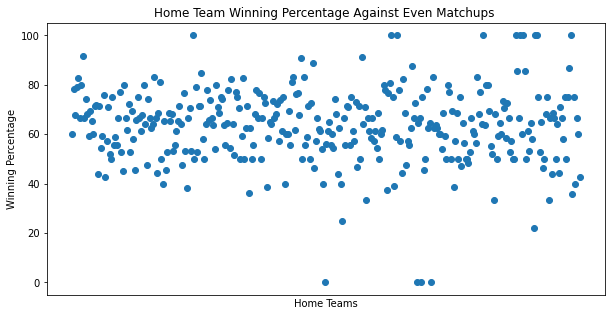

In [ ]:
#@title Plot for "Home Team Winning Percentage Against Even Matchups"
plt.figure(figsize=(10, 5))
plt.scatter(evm["home"], evm["percent_won_at_home"])
plt.title("Home Team Winning Percentage Against Even Matchups ")
plt.xlabel("Home Teams")
plt.ylabel("Winning Percentage")
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

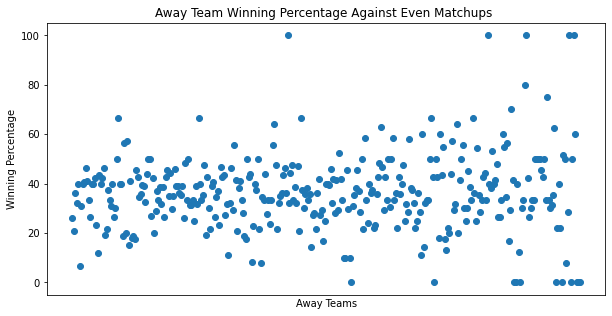

In [ ]:
#@title Plot for "Away Team Winning Percentage Against Even Matchups"
plt.figure(figsize=(10, 5))
plt.scatter(evm["home"], evm["percent_won_at_away"])
plt.title("Away Team Winning Percentage Against Even Matchups")
plt.xlabel("Away Teams")
plt.ylabel("Winning Percentage")
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

Once again, we see that even in even matchups, home court advantage is still an extremely important factor for the hypotheses whe mentioned earlier in our explorations of home court advantage. 

The "Home Team Winning Percentage Against Even Matchups" graph shows that there are more teams that win over 50% of games when they are the home team, and the "Away Team Winning Percentage Against Even Matchups" graph shows that there are more teams that lose over 50% of games when they are the away team.

Home court advantage has proven to be a really important factor thus far.

## Data Exploration: Effect of Team Color on Game Outcome Between Evenly Matched Teams

We wanted to look at if team wearing specific colors, specifically the color red, has an effect on if that team wins or loses. In the past, there have been studies that show a team wearing the color red has a more likely chance of winning. 
(Source: https://www.nytimes.com/2005/05/19/science/research-finds-that-red-is-for-winners.html)

However, while there was an actual study on this that showed a correlation between winning and wearing red, a lot of other researchers have called the findings "absolute rubbish" since there are way too many individual factors that prevent color from being decisive (ie. maybe the star player only got 7 hours of sleep instead of 8, etc).

We hypothesize that there is a belief in teams winning more when wearing red because red subconsciously boosts the player's confidence as it is not only bright, but symbolically associated with strength and power.
(Source: https://www.inc.com/john-boitnott/science-says-wearing-this-color-will-increase-your-odds-of-beating-competition.html)

To look into this phenomenon, we first need to define "red". Our definition of red includes shades of red that tend to fall on the lighter side. A browner red or darker maroon, for example, would not qualify. The hex color range was from '#8f2532' AND '#e51937', where most teams with codes in between this range are shades of red within our criteria with a few exceptions that we manually removed. The manually removed teams usually had colors of some tan/beige/yellow shade. 

Again, we want only even matchups to migitate the effect of a huge difference in the strength of 2 teams. 

Using the `bigquery-public-data.ncaa_basketball.mbb_games_sr` and `bigquery-public-data.ncaa_basketball.team_colors` tables, we look at the percentage of wins by teams wearing red when they are the home team and when they are the away team in even matchups. 

In [ ]:
#@title Query of "Red Teams Win Percentage at Home and Away"
%%bigquery --project $project_id red_color
#red defined as a lighter shade of red, a brownish maroon shade would not count. #8f2532 is the cutoff, orange-ish red counts 
#evenly matched
WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away, 
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), percents2 as (
  SELECT *
  FROM percents
), matchups as (
  SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away, 
    percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
    ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
  FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  WHERE sr.h_market = percents.team AND sr.a_market = percents2.team 
    AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
), matchups_score as (
  SELECT *, IF(h_points_game > a_points_game, 1, 0) as home_won
  FROM matchups
), red as (
  SELECT *
  FROM `bigquery-public-data.ncaa_basketball.team_colors`
  WHERE color BETWEEN '#8f2532' AND '#e51937'
    AND market NOT IN ('Brown', 'Oakland', 'Texas', 'Missouri', 'Clemson', "Oklahoma State", 'Bryant', 'Loyola (MD)', 'Quinnipiac',
    'Georgia Tech','Idaho','UCF','Denver','UMBC','Grambling State','Oral Roberts','Army','Appalachian State','Towson','Tennessee Tech',
    'IUPUI','UMKC','UC Riverside') #manually found teams in the designated red color code region that were not red (mostly yellow and brownish colors)
), home_red_win_percent as (
  SELECT red.market, red.color, ROUND(100.0 * SUM(matchups_score.home_won) / COUNT(matchups_score.home_won),2) as percent_won_as_redhome
  FROM red, matchups_score
  WHERE red.market = matchups_score.home
  GROUP BY red.market, red.color
), away_red_win_percent as (
  SELECT red.market, red.color, 100 - ROUND(100.0 * SUM(matchups_score.home_won) / COUNT(matchups_score.home_won),2) as percent_won_as_redaway
  FROM red, matchups_score
  WHERE red.market = matchups_score.away
  GROUP BY red.market, red.color
), red_win_percents as (
  SELECT home_red_win_percent.market, home_red_win_percent.color, home_red_win_percent.percent_won_as_redhome, away_red_win_percent.percent_won_as_redaway
  FROM home_red_win_percent
  JOIN away_red_win_percent ON home_red_win_percent.market = away_red_win_percent.market
)

SELECT * 
FROM red_win_percents


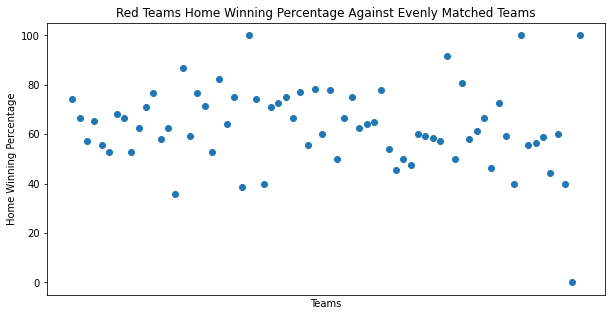

In [ ]:
#@title Plot for "Red Teams Home Winning Percentage Against Evenly Matched Teams"
plt.figure(figsize=(10, 5))
plt.scatter(red_color["market"], red_color["percent_won_as_redhome"])
plt.title("Red Teams Home Winning Percentage Against Evenly Matched Teams")
plt.xlabel("Teams")
plt.ylabel("Home Winning Percentage")
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

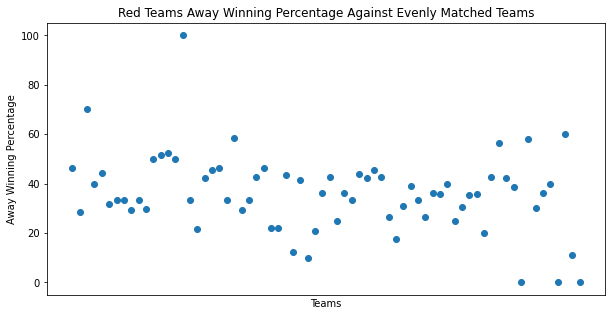

In [ ]:
#@title Plot for "Red Teams Away Winning Percentage Against Evenly Matched Teams"
plt.figure(figsize=(10, 5))
plt.scatter(red_color["market"], red_color["percent_won_as_redaway"])
plt.title("Red Teams Away Winning Percentage Against Evenly Matched Teams")
plt.xlabel("Teams")
plt.ylabel("Away Winning Percentage")
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)

Looking at the data, we see that more red teams win over than 50% of games at home whereas more red teams lose over 50% of games at away. From these findings, we can probably draw that the team's color is not a game changing factor as the plot distributions in this exploration look similar to other explorations above.

We hypothesize red not being a huge contributor in game outcome just simply because there are way more other individual tangible factors that can affect a game's outcome (ie. team's star player's pregame meal was overcooked which led to a below average performance, etc). 

Additionally, we hypothesized that red may subconsiously boost one's confidence to play better due to the associations that come with the color. However, on the topic of the subconciousness, we believe that this psychological effect is not limited to just the color red. For example, if a player's favorite color is green, he/she may be more confident sporting that color and thus lead to more confidence on the court leading to a better game. Red is also not the only color associated with winning, as the NCAA shows that there are many other color combos such as ones involving blue that have a higher winning percentage. 
(Source: http://wearefanatics.com/march-madness-color-analysis/)

Because of all these findings and conclusions, it is safe to say that even amongst evenly matched teams, a team's color does not matter all that much whereas the home court advantage still does.

## Data Exploration: Effect of Average Class On Game Outcomes




One of our questions we hoped to answer was how the average class of a player on a team impacts the outcome of games. This question will be interesting to explore because on one hand, many of the most talented players are freshman phenoms like Zion Wiliamson was but, on the other hand, experience comes with age. To answer this question, we will use the `bigquery-public-data.ncaa_basketball.mbb_players_games_sr` dataset, which has information on the class of each player on each team that we will use to calculate the average class for each team. We will then use the win percentages of each team (we calculated this earlier) to get a complete set of data with which we can compare average class of player and win percentage.

For this exporation, we will not be comparing restricting ourselves to even matchups since we want to see if significant differences in team records can be attributed to differences in class/age.

In [ ]:
#@title Query of "Average Class of Team and Team Winning Percentage"
%%bigquery --project $project_id avg_class_win_percent

WITH won_home as (SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr), win_h_percentage as (SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played FROM won_home GROUP BY home_team HAVING COUNT(win) > 0), won_away as (SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr), win_a_percentage as (SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played FROM won_away GROUP BY away_team HAVING COUNT(win) > 0 ), percents as ( SELECT win_percent_as_home, win_percent_as_away,  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team FROM win_h_percentage JOIN win_a_percentage ON away_team = home_team WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0)
, table1 AS (
  SELECT
    first_name,
    last_name,
    team_market,
    CASE
      WHEN class='FR' THEN 0
      WHEN class='SO' THEN 1
      WHEN class='JR' THEN 2 
      WHEN class='SR' THEN 3
      WHEN class='GR' THEN 4
      ELSE NULL
    END AS class
  FROM
    `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
  GROUP BY
    first_name,
    last_name,
    team_market,
    class),
class_avgs AS (SELECT
  team_market, AVG(class) as avg_class
FROM
  (SELECT * FROM table1 WHERE class IS NOT NULL)
GROUP BY 
  team_market),
class_and_percents AS (SELECT team_market, avg_class, total_win_percent FROM class_avgs JOIN percents ON percents.team = class_avgs.team_market)
SELECT * FROM class_and_percents


Correlation Coefficient:
-0.13357586961520831


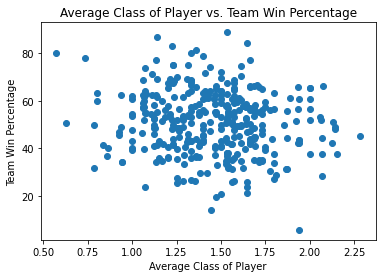

In [ ]:
#@title Plot for "Average Class of Team and Team Winning Percentage"
plt.figure()
plt.scatter(avg_class_win_percent["avg_class"], avg_class_win_percent["total_win_percent"])
plt.title("Average Class of Player vs. Team Win Percentage")
plt.xlabel("Average Class of Player")
plt.ylabel("Team Win Percentage")
print("Correlation Coefficient:\n" + str((np.corrcoef(avg_class_win_percent["avg_class"], avg_class_win_percent["total_win_percent"])[0][1])))

In the above graph, it's hard to see a strong correlation between the average class of a team and team win percentage. It's likely the case that average class isn't a significant factor in determining win percentage (team performance/game outcomes). However, using numpy, we can see that there is a small negative correlation between team win percentage and the average class of a player (-0.13). This could imply that younger teams may often outperform their older counterparts, and that average class has at least some weight in determining game outcomes. One reason for this could be the existence of many freshman phenoms who then leave to the NBA after one year, like mentioned above. Nonetheless, more research would be helpful. 

## Data Exploration: Effect of Attendance on Game Outcomes

A final factor we wanted to explore was how attendance of games, both in home and away games, would affect team performance/game outcomes. We hypothesize that the size of the crowd could have significant effects on the psyches of players, and would especially help home teams perform better.

For all matchups, we will look at how attendance at home affects the home team's performance and, conversely, how attendence at the opponent's venue affects the away team's performance. Then, we will restrict ourselves to even matchups, and look at the same two metrics. To do so, we will find average attendance using `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` and get win percentage at home/away from our earlier explorations.



In [ ]:
#@title Query for "Home Attendance Effect on Home Team (All Matchups)"
%%bigquery --project $project_id home_team_attendance_wins_all
WITH home_teams_attendance AS (SELECT market as home_team, avg(attendance) as avg_attendance FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` WHERE neutral_site IS NULL AND attendance IS NOT NULL AND home_team=true GROUP BY home_team),
won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away, 
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
)
SELECT avg_attendance, win_percent_as_home FROM home_teams_attendance JOIN percents ON percents.team = home_teams_attendance.home_team

Correlation Coefficient:
0.4777113111241382


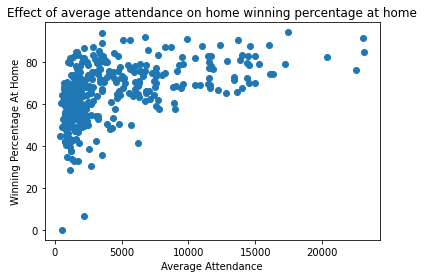

In [ ]:
#@title Plot for "Home Attendance Effect on Home Team (All Matchups)"
plt.figure()
plt.scatter(home_team_attendance_wins_all["avg_attendance"], home_team_attendance_wins_all["win_percent_as_home"])
plt.title("Effect of average attendance on home winning percentage at home")
plt.xlabel("Average Attendance")
plt.ylabel("Winning Percentage At Home")
print("Correlation Coefficient:\n" + str((np.corrcoef(home_team_attendance_wins_all["avg_attendance"], home_team_attendance_wins_all["win_percent_as_home"])[1][0])))

In [ ]:
#@title Query for "Home Attendance Effect on Away Team (All Matchups)"
%%bigquery --project $project_id away_team_attendance_wins_all
WITH away_teams_attendance AS (SELECT market as away_team, avg(attendance) as avg_attendance FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` WHERE neutral_site IS NULL AND attendance IS NOT NULL AND home_team=false GROUP BY away_team),
won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away, 
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
)
SELECT avg_attendance, win_percent_as_away FROM away_teams_attendance JOIN percents ON percents.team = away_teams_attendance.away_team

Correlation Coefficient:
0.325926484853903


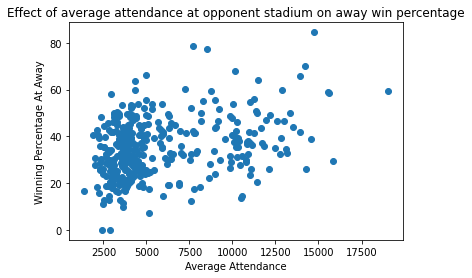

In [ ]:
#@title Plot for "Home Attendance Effect on Away Team (All Matchups)"
plt.figure()
plt.scatter(away_team_attendance_wins_all["avg_attendance"], away_team_attendance_wins_all["win_percent_as_away"])
plt.title("Effect of average attendance at opponent stadium on away win percentage")
plt.xlabel("Average Attendance")
plt.ylabel("Winning Percentage At Away")
print("Correlation Coefficient:\n" + str((np.corrcoef(away_team_attendance_wins_all["avg_attendance"], away_team_attendance_wins_all["win_percent_as_away"])[1][0])))

In [ ]:
#@title Query for "Home Attendance Effect on Home Team (Even Matchups)"
#WIN LOSS % AGAINST EVENLY MATCHED TEAMS
%%bigquery --project $project_id attendance_evenly_matched
WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away,
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), percents2 as (
  SELECT *
  FROM percents
), matchups as (
  SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
    percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
    ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
  FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
    AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
), matchups_score_home as (
  SELECT *, IF(h_points_game > a_points_game, 1, 0) as home_won
  FROM matchups
), matchups_score_away as (
  SELECT *, IF(h_points_game < a_points_game, 1, 0) as away_won
  FROM matchups
), homeRecord as (
  SELECT matchups_score_home.home, SUM(home_won) as homeWon, COUNT(home_won) as home_played, ROUND(100.0 * SUM(home_won)/COUNT(home_won), 2) as percent_won_at_home
  FROM matchups_score_home
  GROUP BY matchups_score_home.home
), awayRecord as (
  SELECT matchups_score_away.away, SUM(away_won) as awayWon, COUNT(away_won) as away_played,
    ROUND(100.0 * SUM(away_won)/COUNT(away_won), 2) as percent_won_at_away
  FROM matchups_score_away
  GROUP BY matchups_score_away.away
), totalRecordsEvenMatched as (
  SELECT homeRecord.home, homeRecord.percent_won_at_home, awayRecord.percent_won_at_away
  FROM homeRecord
  JOIN awayRecord ON homeRecord.home = awayRecord.away
),
home_teams_attendance AS (SELECT market as home_team, avg(attendance) as avg_attendance FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` WHERE neutral_site IS NULL AND attendance IS NOT NULL AND home_team=true GROUP BY home_team)
SELECT avg_attendance, percent_won_at_home FROM home_teams_attendance JOIN totalRecordsEvenMatched ON totalRecordsEvenMatched.home = home_teams_attendance.home_team

Correlation Coefficient:
0.21150235703727938


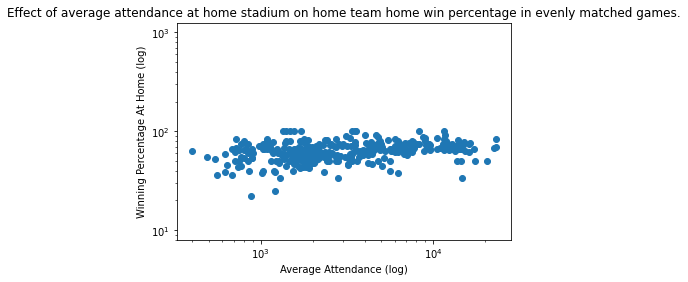

In [ ]:
#@title Plot for "Home Attendance Effect on Home Team (Even Matchups)"
plt.figure()
plt.scatter(attendance_evenly_matched["avg_attendance"], attendance_evenly_matched["percent_won_at_home"])
plt.title("Effect of average attendance at home stadium on home team home win percentage in evenly matched games.")
plt.xlabel("Average Attendance (log)")
plt.ylabel("Winning Percentage At Home (log)")
plt.yscale('log')
plt.xscale('log')
print("Correlation Coefficient:\n" + str((np.corrcoef(attendance_evenly_matched["avg_attendance"], attendance_evenly_matched["percent_won_at_home"])[1][0])))

In [ ]:
#@title Query for "Home Attendance Effect on Away Team (Even Matchups)"
%%bigquery --project $project_id attendance_evenly_matched_away
WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away,
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), percents2 as (
  SELECT *
  FROM percents
), matchups as (
  SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
    percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
    ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
  FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
    AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
), matchups_score_home as (
  SELECT *, IF(h_points_game > a_points_game, 1, 0) as home_won
  FROM matchups
), matchups_score_away as (
  SELECT *, IF(h_points_game < a_points_game, 1, 0) as away_won
  FROM matchups
), homeRecord as (
  SELECT matchups_score_home.home, SUM(home_won) as homeWon, COUNT(home_won) as home_played, ROUND(100.0 * SUM(home_won)/COUNT(home_won), 2) as percent_won_at_home
  FROM matchups_score_home
  GROUP BY matchups_score_home.home
), awayRecord as (
  SELECT matchups_score_away.away, SUM(away_won) as awayWon, COUNT(away_won) as away_played,
    ROUND(100.0 * SUM(away_won)/COUNT(away_won), 2) as percent_won_at_away
  FROM matchups_score_away
  GROUP BY matchups_score_away.away
), totalRecordsEvenMatched as (
  SELECT homeRecord.home, homeRecord.percent_won_at_home, awayRecord.percent_won_at_away
  FROM homeRecord
  JOIN awayRecord ON homeRecord.home = awayRecord.away
),
away_teams_attendance AS (SELECT market as away_team, avg(attendance) as avg_attendance FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` WHERE neutral_site IS NULL AND attendance IS NOT NULL AND home_team=false GROUP BY away_team)
SELECT avg_attendance, percent_won_at_away FROM away_teams_attendance JOIN totalRecordsEvenMatched ON totalRecordsEvenMatched.home = away_teams_attendance.away_team

Correlation Coefficient:
0.11544302394389601


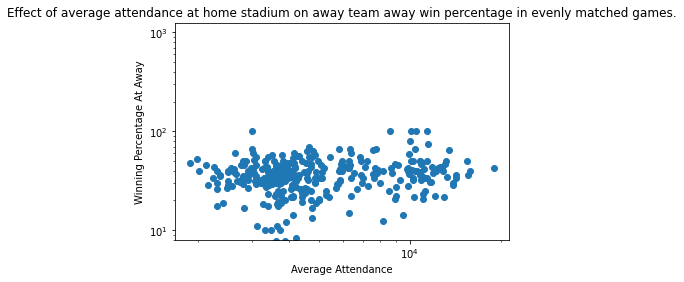

In [ ]:
#@title Plot for "Home Attendance Effect on Away Team (Even Matchups)"
plt.figure()
plt.scatter(attendance_evenly_matched_away["avg_attendance"], attendance_evenly_matched_away["percent_won_at_away"])
plt.title("Effect of average attendance at home stadium on away team away win percentage in evenly matched games.")
plt.xlabel("Average Attendance")
plt.ylabel("Winning Percentage At Away")
plt.yscale('log')
plt.xscale('log')
print("Correlation Coefficient:\n" + str((np.corrcoef(attendance_evenly_matched_away["avg_attendance"], attendance_evenly_matched_away["percent_won_at_away"])[1][0])))

As shown by the above plots and correlation coefficients, it turns out that win percentage and average attendance are positively correlated in each of these 4 cases. We realize that this is likely partly because a higher win percentage means a better team which means more interest and larger crowds. It was difficult to isolate the pure effect of the crowd on game performance, since external factors like fans gravitating towards better teams exist. Improving this exploration is beyond the scope of this project, as it currently stands but we will have some interesting findings.

For example, it can be seen that in both even matchups and all matchups, the positive correlation between home attendance and the home team winning was higher than that between home attendance and the away team winning. As mentioned above, higher win percentages result in higher average attendances in general, but the home team winning being more strongly correlated with attendance at the home venue could be attributed to home team advantage and the psychological effects of having fans behind you to energize and reinvigorate you. This exploration contributes to the answer of "yes" in favor of the home team to our question of "does game location affect outcomes?" 

## Data Exploration: Effect of Attendance on Three-point Shooting

So far, we have looked at game outcomes, but what about some of the finer details of the game. One of the most focus-intensive plays in the sport is the three-point shot. Larger crowds means more noise, more heckling, and more distractions. Could this impact a player's ability to focus and knock down three-pointers? If we failed to look at some of the game's finer details, we could miss out on some truly fascinating results that underpin game outcomes. This is what has inspired this section.

To get data on three-point shot attempts and makes, we will use `bigquery-public-data.ncaa_basketball.mbb_pbp_sr`.

In [ ]:
#@title Query for "Effect of Attendance on Three-point Shooting"
%%bigquery --project $project_id attendance_effect_on_3p
SELECT DISTINCT
  game_id,
  attendance,
  SUM(CASE WHEN shot_made=true THEN 1 ELSE 0 END) / SUM(CASE WHEN three_point_shot=true THEN 1 ELSE 0 END) as three_point_percentage
FROM
  `bigquery-public-data.ncaa_basketball.mbb_pbp_sr`
WHERE
  three_point_shot = true 
GROUP BY
  game_id,
  attendance
HAVING 
  three_point_percentage IS NOT NULL AND
  attendance IS NOT NULL


Correlation Coefficient:
0.004739402128736532


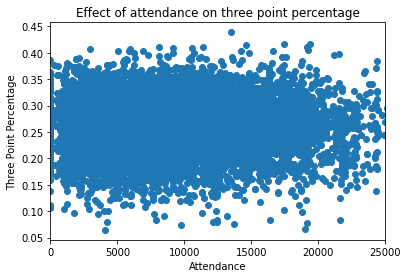

In [ ]:
#@title Plot for "Effect of Attendance on Three-point Shooting"
plt.figure()
plt.xlim(0, 25000)
plt.scatter(attendance_effect_on_3p["attendance"], attendance_effect_on_3p["three_point_percentage"])
plt.title("Effect of attendance on three point percentage")
plt.xlabel("Attendance")
plt.ylabel("Three Point Percentage")
print("Correlation Coefficient:\n" + str((np.corrcoef(attendance_effect_on_3p["attendance"], attendance_effect_on_3p["three_point_percentage"])[1][0])))

In the above data, we trimmed off some outliers, but the story remains the same. Attendance is not significantly corrrelated with three-point make percentage. There is a slight positive correlation of .0047, but this is so small that it's safe to assume that our hypothesis of attendance affecting player/team performance with respect to three-point shooting was incorrect or at least inconclusive.

## Data Prediction: Our ML Model

In each prediction model, we will be using features if the home team wins (home_win) as the label, if the home team has a higher win percentage than the away team (hometeam_stronger), the home team's total win percentage (total_win_percent_home), the away team's total win percentage (total_win_percent_away), the absolute value of the difference in win percentages (percent_diff). We will divide up the training, validation, and test sets by scheduled date and the percent_diff. 

Two additional metrics that have no correlation with stats are also considered: one is the average class (frosh/soph/jr/sr/gr) of each teams and the other is attendance (how many people come watch the game). With all the above features held constant, we wanted to see which of these two non-statistic features yielded better prediction results. In total, we will have three models: one with all the above features, one with all the above features mentioned and also player class, and one with all the above features mentioned and also attendance.

In our data exploration, we discovered higher average player class is correlated with a lower win percentage (younger avg. player class correlate with mroe wins. We also discovered that higher attendance is correlated with higher win percentage for both teams, with a stronger correlation for the home team (due to home team advantage). 

With this in mind, we wanted to use these 2 stats as features to see how it could improve our model's prediction, and which would be a stronger feature to use for predictions if any is. 

For my training set, I limited my data to percent_diff < 4.0 AND scheduled_date < '2017-06-01'. 

For my evaluation set, I limited my data to percent_diff < 4.0 AND '2017-06-01' < scheduled_date AND scheduled_date < '2018-03-28'.

For my prediction set, I used unseen data that is where 4.0 <= percent_diff  AND percent_diff < 5.0.


## Model for No Player Class or Attendance

In [ ]:
#@title Query: No Player Class or Attendance
%%bigquery --project $project_id 

WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away,
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), percents2 as (
  SELECT *
  FROM percents
), matchups as (
  SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
    percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
    ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
  FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
    AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
), even_matches AS (
  SELECT sr.attendance, matchups.game_id, home, away, 
   total_win_percent_home, total_win_percent_away, percent_diff,
   IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
   scheduled_date 
  FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
  JOIN matchups ON matchups.game_id = sr.game_id
), final as (
SELECT DISTINCT(game_id), attendance, home, away,
  total_win_percent_home, total_win_percent_away, percent_diff, home_win,
  scheduled_date
FROM even_matches
WHERE attendance IS NOT NULL
), less_four as (
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    total_win_percent_home, total_win_percent_away, percent_diff, 
    scheduled_date
  FROM final
  WHERE percent_diff < 4.0
)
SELECT *
FROM less_four

In [ ]:
model_dataset_name = 'zregular'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('project3-334106', 'zregular'))

In [ ]:
#@title Create Model: No Player Class or Attendance
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `zregular.reg` -- we'll call our model 'attendance_m'
OPTIONS (model_type='logistic_reg') AS ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  )
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    scheduled_date
  FROM final
  WHERE percent_diff < 4.0 AND scheduled_date < '2017-06-01'
)

""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `zregular.reg`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,2,0.609283,0.666109,0.8,2320
1,0,1,0.648166,0.674378,0.4,2342
2,0,0,0.676241,0.685316,0.2,2251


In [ ]:
#@title Evaluate: No Player Class or Attendance
%%bigquery --project $project_id
#EVALUATE
SELECT
  *
FROM ML.EVALUATE(MODEL `zregular.reg`, ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  )
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    scheduled_date
  FROM final
  WHERE percent_diff < 4.0 AND '2017-06-01' < scheduled_date AND scheduled_date < '2018-03-28'
))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.660513,0.996904,0.659161,0.794571,0.6705,0.528645


In [ ]:
#@title Predict: No Player Class or Attendance
%%bigquery --project $project_id
#PREDICT
SELECT
  *
FROM ML.PREDICT(MODEL `zregular.reg`, ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
      AND ABS(percents.total_win_percent - percents2.total_win_percent) >= 4
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  )
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
     total_win_percent_home, total_win_percent_away, percent_diff,
    scheduled_date
  FROM final
  WHERE 4.0 <= percent_diff  AND percent_diff < 5.0 #unseen data
))


## Model with Player Class

In [ ]:
#@title Query: Player Class
%%bigquery --project $project_id 

WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away,
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), percents2 as (
  SELECT *
  FROM percents
), matchups as (
  SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
    percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
    ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
  FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
    AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
), even_matches AS (
  SELECT sr.attendance, matchups.game_id, home, away, 
   total_win_percent_home, total_win_percent_away, percent_diff,
   IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
   scheduled_date 
  FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
  JOIN matchups ON matchups.game_id = sr.game_id
), final as (
SELECT DISTINCT(game_id), attendance, home, away,
  total_win_percent_home, total_win_percent_away, percent_diff, home_win,
  scheduled_date
FROM even_matches
WHERE attendance IS NOT NULL
), less_four as ( # WHAT WE ARE CHANGING
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
    scheduled_date, home, away
  FROM final
  WHERE percent_diff < 4.0
), table1 AS (
  SELECT
    first_name,
    last_name,
    team_market,
    CASE
      WHEN class='FR' THEN 0
      WHEN class='SO' THEN 1
      WHEN class='JR' THEN 2 
      WHEN class='SR' THEN 3
      WHEN class='GR' THEN 4
      ELSE NULL
    END AS class
  FROM
    `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
  GROUP BY
    first_name,
    last_name,
    team_market,
    class
),class_avgs AS (
  SELECT team_market, AVG(class) as avg_class
  FROM (SELECT * FROM table1 WHERE class IS NOT NULL)
  GROUP BY team_market
), class_and_percents AS (
  SELECT team_market, avg_class, total_win_percent 
  FROM class_avgs JOIN percents ON percents.team = class_avgs.team_market
), train as (
  SELECT label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
    scheduled_date, avg_class as home_avg_class, away
  FROM less_four
  JOIN class_and_percents ON class_and_percents.team_market = home
), train_final as (
 SELECT label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    total_win_percent_home, total_win_percent_away, percent_diff, 
    scheduled_date, home_avg_class, avg_class as away_avg_class
    FROM train
    JOIN class_and_percents ON class_and_percents.team_market = away
)
  SELECT * 
  FROM train_final

In [ ]:
model_dataset_name = 'zmy_model'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('project3-334106', 'zmy_model'))

In [ ]:
#@title Create Model: Player Class
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `zmy_model.mod` 
OPTIONS (model_type='logistic_reg') AS ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  ), less_four as ( # WHAT WE ARE CHANGING
    SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
      attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, home, away
    FROM final
    WHERE percent_diff < 4.0 AND scheduled_date < '2017-06-01'
  ), table1 AS (
    SELECT
      first_name,
      last_name,
      team_market,
      CASE
        WHEN class='FR' THEN 0
        WHEN class='SO' THEN 1
        WHEN class='JR' THEN 2 
        WHEN class='SR' THEN 3
        WHEN class='GR' THEN 4
        ELSE NULL
      END AS class
    FROM
      `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
    GROUP BY
      first_name,
      last_name,
      team_market,
      class
  ),class_avgs AS (
    SELECT team_market, AVG(class) as avg_class
    FROM (SELECT * FROM table1 WHERE class IS NOT NULL)
    GROUP BY team_market
  ), class_and_percents AS (
    SELECT team_market, avg_class, total_win_percent 
    FROM class_avgs JOIN percents ON percents.team = class_avgs.team_market
  ), train as (
    SELECT label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
      attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, avg_class as home_avg_class, away
    FROM less_four
    JOIN class_and_percents ON class_and_percents.team_market = home
  ), train_final as (
  SELECT label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
      total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, home_avg_class, avg_class as away_avg_class
      FROM train
      JOIN class_and_percents ON class_and_percents.team_market = away
  )
    SELECT * 
    FROM train_final
)

""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `zmy_model.mod`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,2,0.607438,0.662458,0.8,2265
1,0,1,0.647034,0.672961,0.4,2443
2,0,0,0.675783,0.684876,0.2,2166


In [ ]:
#@title Evaluate: Player Class
%%bigquery --project $project_id
#EVALUATE
SELECT
  *
FROM ML.EVALUATE(MODEL `zmy_model.mod`, ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  ), less_four as ( # WHAT WE ARE CHANGING
    SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
      attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, home, away
    FROM final
    WHERE percent_diff < 4.0 AND '2017-06-01' < scheduled_date AND scheduled_date < '2018-03-28'
  ), table1 AS (
    SELECT
      first_name,
      last_name,
      team_market,
      CASE
        WHEN class='FR' THEN 0
        WHEN class='SO' THEN 1
        WHEN class='JR' THEN 2 
        WHEN class='SR' THEN 3
        WHEN class='GR' THEN 4
        ELSE NULL
      END AS class
    FROM
      `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
    GROUP BY
      first_name,
      last_name,
      team_market,
      class
  ),class_avgs AS (
    SELECT team_market, AVG(class) as avg_class
    FROM (SELECT * FROM table1 WHERE class IS NOT NULL)
    GROUP BY team_market
  ), class_and_percents AS (
    SELECT team_market, avg_class, total_win_percent 
    FROM class_avgs JOIN percents ON percents.team = class_avgs.team_market
  ), train as (
    SELECT label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
      attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, avg_class as home_avg_class, away
    FROM less_four
    JOIN class_and_percents ON class_and_percents.team_market = home
  ), train_final as (
  SELECT label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
      total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, home_avg_class, avg_class as away_avg_class
      FROM train
      JOIN class_and_percents ON class_and_percents.team_market = away
  )
    SELECT * 
    FROM train_final
))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.659398,0.982972,0.653019,0.78931,0.670868,0.518704


In [ ]:
#@title Predict: Player Class
%%bigquery --project $project_id
#PREDICT
SELECT
  *
FROM ML.PREDICT(MODEL `zmy_model.mod`, ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  ), less_four as ( # WHAT WE ARE CHANGING
    SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
      attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, home, away
    FROM final
    WHERE 4.0 <= percent_diff  AND percent_diff < 5.0 #unseen data
  ), table1 AS (
    SELECT
      first_name,
      last_name,
      team_market,
      CASE
        WHEN class='FR' THEN 0
        WHEN class='SO' THEN 1
        WHEN class='JR' THEN 2 
        WHEN class='SR' THEN 3
        WHEN class='GR' THEN 4
        ELSE NULL
      END AS class
    FROM
      `bigquery-public-data.ncaa_basketball.mbb_players_games_sr`
    GROUP BY
      first_name,
      last_name,
      team_market,
      class
  ),class_avgs AS (
    SELECT team_market, AVG(class) as avg_class
    FROM (SELECT * FROM table1 WHERE class IS NOT NULL)
    GROUP BY team_market
  ), class_and_percents AS (
    SELECT team_market, avg_class, total_win_percent 
    FROM class_avgs JOIN percents ON percents.team = class_avgs.team_market
  ), train as (
    SELECT label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
      attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, avg_class as home_avg_class, away
    FROM less_four
    JOIN class_and_percents ON class_and_percents.team_market = home
  ), train_final as (
  SELECT label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
       total_win_percent_home, total_win_percent_away, percent_diff, 
      scheduled_date, home_avg_class, avg_class as away_avg_class
      FROM train
      JOIN class_and_percents ON class_and_percents.team_market = away
  )
    SELECT * 
    FROM train_final
))

## Model with Attendance 

In [ ]:
#@title Query: Attendance 
%%bigquery --project $project_id 

WITH won_home as ( # get wins and losses when team is home
  SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_h_percentage as ( # win percentage of team as away team
  SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
  FROM won_home
  GROUP BY home_team
  HAVING COUNT(win) > 0 #so at least 1 game played at home
), won_away as (
  SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
  FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
), win_a_percentage as ( # win percentage of team as away team
  SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
  FROM won_away
  GROUP BY away_team
  HAVING COUNT(win) > 0 #so at least 1 game played at away
), percents as (
  SELECT win_percent_as_home, win_percent_as_away,
  ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
  FROM win_h_percentage
  JOIN win_a_percentage ON away_team = home_team
  WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
), percents2 as (
  SELECT *
  FROM percents
), matchups as (
  SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
    percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
    ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
  FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
    AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
), even_matches AS (
  SELECT sr.attendance, matchups.game_id, home, away, 
   total_win_percent_home, total_win_percent_away, percent_diff,
   IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
   scheduled_date 
  FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
  JOIN matchups ON matchups.game_id = sr.game_id
), final as (
SELECT DISTINCT(game_id), attendance, home, away,
  total_win_percent_home, total_win_percent_away, percent_diff, home_win,
  scheduled_date
FROM even_matches
WHERE attendance IS NOT NULL
), less_four as (
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    attendance, total_win_percent_home, total_win_percent_away, percent_diff, 
    scheduled_date
  FROM final
  WHERE percent_diff < 4.0
)
SELECT *
FROM less_four






In [ ]:
model_dataset_name = 'zattend_mod'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('project3-334106', 'zattend_mod'))

In [ ]:
#@title Create Model: Attendance 
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `zattend_mod.attendance_m` -- we'll call our model 'attendance_m'
OPTIONS (model_type='logistic_reg') AS ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  )
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    attendance, total_win_percent_home, total_win_percent_away, percent_diff,
    scheduled_date
  FROM final
  WHERE percent_diff < 4.0 AND scheduled_date < '2017-06-01'
)

""


In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `zattend_mod.attendance_m`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,3,0.573726,0.647058,1.6,3092
1,0,2,0.611464,0.649780,0.8,2252
2,0,1,0.649168,0.666504,0.4,4169
3,0,0,0.676575,0.682506,0.2,2228


In [ ]:
#@title Evaluate: Attendance 
%%bigquery --project $project_id
#EVALUATE
SELECT
  *
FROM ML.EVALUATE(MODEL `zattend_mod.attendance_m`, ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  )
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    attendance, total_win_percent_home, total_win_percent_away, percent_diff,
    scheduled_date
  FROM final
  WHERE percent_diff < 4.0 AND '2017-06-01' < scheduled_date AND scheduled_date < '2018-03-28'
))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.662148,0.982972,0.657114,0.791277,0.659645,0.538984


In [ ]:
#@title Predict: Attendance
%%bigquery --project $project_id
#PREDICT
SELECT
  *
FROM ML.PREDICT(MODEL `zattend_mod.attendance_m`, ( 
  WITH won_home as ( # get wins and losses when team is home
    SELECT sr.h_market as home_team, IF(sr.h_points_game > sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_h_percentage as ( # win percentage of team as away team
    SELECT home_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_home, SUM(win) as home_wins, COUNT(win) as home_played
    FROM won_home
    GROUP BY home_team
    HAVING COUNT(win) > 0 #so at least 1 game played at home
  ), won_away as (
    SELECT sr.a_market as away_team, IF(sr.h_points_game < sr.a_points_game, 1, 0) as win
    FROM `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
  ), win_a_percentage as ( # win percentage of team as away team
    SELECT away_team, ROUND(100.0 * SUM(win) / COUNT(win), 2) as win_percent_as_away, SUM(win) as away_wins, COUNT(win) as away_played
    FROM won_away
    GROUP BY away_team
    HAVING COUNT(win) > 0 #so at least 1 game played at away
  ), percents as (
    SELECT win_percent_as_home, win_percent_as_away,
    ROUND(100.0 * (home_wins + away_wins) / (away_played + home_played), 2) as total_win_percent, home_team as team
    FROM win_h_percentage
    JOIN win_a_percentage ON away_team = home_team
    WHERE win_percent_as_home > 0.0 OR win_percent_as_away > 0.0 #gets rid of teams that didn't win at all (13 rows)
  ), percents2 as (
    SELECT *
    FROM percents
  ), matchups as (
    SELECT DISTINCT(game_id), sr.h_market as home, sr.a_market as away,
      percents.total_win_percent as total_win_percent_home, percents2.total_win_percent as total_win_percent_away,
      ABS(percents.total_win_percent - percents2.total_win_percent) as percent_diff, h_points_game, a_points_game
    FROM percents, percents2, `bigquery-public-data.ncaa_basketball.mbb_games_sr` as sr
    WHERE sr.h_market = percents.team AND sr.a_market = percents2.team
      AND ABS(percents.total_win_percent - percents2.total_win_percent) < 5
      AND ABS(percents.total_win_percent - percents2.total_win_percent) >= 4
  ), even_matches AS (
    SELECT sr.attendance, matchups.game_id, home, away, 
    total_win_percent_home, total_win_percent_away, percent_diff,
    IF(matchups.h_points_game > matchups.a_points_game, 1, 0) as home_win, 
    scheduled_date 
    FROM `bigquery-public-data.ncaa_basketball.mbb_teams_games_sr` sr 
    JOIN matchups ON matchups.game_id = sr.game_id
  ), final as (
  SELECT DISTINCT(game_id), attendance, home, away,
    total_win_percent_home, total_win_percent_away, percent_diff, home_win,
    scheduled_date
  FROM even_matches
  WHERE attendance IS NOT NULL
  )
  SELECT home_win as label, IF(total_win_percent_home > total_win_percent_away, 1, 0) AS hometeam_stronger, 
    attendance, total_win_percent_home, total_win_percent_away, percent_diff,
    scheduled_date
  FROM final
  WHERE 4.0 <= percent_diff  AND percent_diff < 5.0 #unseen data
))

LIMIT 10

---

Looking at our results, we see our model with no player class and no attendance has the highest accuracy of 0.659, the model with attendance and no player class coming in second with 0.657, and the model with player class and not attendance last at 0.653. All models are pretty close to each other in terms of accuracy, which makes us believe that while attendance and player class may have some correlation to winning, there are other more statistical-oritented features that may have more of an effect on the accuracy of the models. 

All of the models tended to have a pretty high recall, with the model with no player class and no attended with the highest recall of 0.997. The other two models both have recalls around 0.98. This means that our model has a lot more false positives than false negatives, namely a lot more cases where we predict the home team to win although they do not. We think that a reason for this is because of the emphasis on home court advantage. Throughout our data exploration, we say that home court exploration may have the largest effect on a team's winning perentage compared to other things like color, attendance, etc. Because our models uses many specific features that depend on whether a team is home or away, despite having other features like attendance and player class, in the face of a stronger feature like home court advantage, the other metrics may not matter too much. Our models may place too much of an emphasis on whether a team is the home team or not, which could explain why there are so many false positives where the home team is favored in situations where they actually lose. 

Regardless, it was interesting to observe how attendance and player class could affect the predictions that our model would make. 

---

## Conclusion

In our explorations, we found that some factors external to NCAA gameplay itself affect outcomes/performance, but that they do so to varying degrees and some may not do anything at all. More specifically, we analyzed the effects of team color, venue attendance, the venue location (home or away), and average class (freshman, sophomore, junior, senior, grad student) of the teams on game outcomes/performances, as well as three-pointer make percentage in relation to attendance.
 
We found that factors like game venue have great effect on game outcomes, while factors like game attendance and average class have potential effects on game outcomes, and finally that factors like team color have little to no effect on game outcome and attendance has little to no effect on three-point make percentage.
 
First, in regards to the game venue's effect on game outcomes, we showed that 361/362 teams won more games at home as opposed to when they were visitors. This was the first clear indication that the legend of "home field advantage" is likely a true one. We then dove deeper into this factor of venue by plotting winning percentage at home for all teams vs. when away and it became visible that the distributions were very different. Many more teams won over 50% of games at home while more teams lost over 50% of games away. This clear difference in distribution leads us to believe that our hypothesis of venue location affecting outcomes is likely true and the team at home is advantaged by the venue location. The correlation found between being at home and higher winning percentage can likely be attributed to things like comfortability and support of fans etc. These findings also held true when looking at matchups between evenly matched teams, which helped us isolate this variable more. However, we do recognize that home field advantage is very difficult to truly capture, since there are so many different factors like "hotness" (win streaks etc.) going into a game and difficulty of previous schedule etc. that we didn't account for.
 
Next, higher game attendance was correlated to higher win percentages in all the cases we explored. We thought that this wouldn't be the case for visiting teams that visit packed home arenas of fans booing them. However, our analysis doesn't completely isolate, even in our "even matchups", the fact that teams with higher win percentages will likely attract larger crowds since they are bigger. It's likely that this fact overruled the factor of home team heckling of the visiting team. All in all, we still found that home teams had a stronger correlation to higher winning percentage when they averaged more home attendance. We hypothesize that this goes back to home team advantage, and is because these home teams get extra support from fans and have a sense of pride at home/comfort, giving them an edge.
 
As for average class, younger teams were correlated with higher win percentages. One might think that this contradicts "practice makes perfect" and the fact that people often improve with experience, but often the best players in the NCAA are freshman phenoms. Again, this was a non-gametime statistic that potentially had some effect on outcomes. Again, our analysis could be skewed by the fact that teams that are better have a higher chance of attracting freshman talent and get younger this way.
 
Finally, team color did not affect outcomes significantly, despite studies showing that red is advantageous. This is likely because those studies were flawed or perhaps this is just inconclusive for this particular dataset, but it appears wearing red doesn't make a team better, even when evenly matched.
 
It also turns out that three-pointers made percentage isn't correlated with crowd size significantly. This was surprising to us.
 
Ultimately, we found that there are a handful of factors external to gametime statistics that affect outcomes/performances of NCAA games, but we can only hypothesize about the reasons why. These factors have different weights and some likely don't matter at all. More research is needed to uncover and isolate the effects of complex features like home team advantage etc. After all, there's a reason the NBA hires whole teams of people to do these computations. 
 
